# Experiment on a real dataset

This notebook follows the reproduction of the paper's experiment. Here, we apply the Sinkhirn kernel on a real dataset provided [by Safran here](https://plaid-lib.readthedocs.io/en/latest/source/data_challenges/rotor37.html). The data is composed of 3D modelisations of motor blades. Those blades are represented by a cloud points. 

The goal of this notebook is to perform regression task with X variable being the cloud points of the blade (one cloud point = 1 blade = 1 observation) and the target variable Y is a aerodynamic coefficient provided with the metadata of the blade. 
- We are going to carry this task using the Sinkhorn kernel of our [paper of interest](https://doi.org/10.48550/arXiv.2210.06574). 
- After that, we aim at using other kernel to carry out Kernel Ridge Regression, namely the Wassestein kernel and the Sliced Wasserstein kernel, and compare accuracy and computation efficiency of those different methods against the Sinkhorn kernel. 
- If time allows, the goal is to perform this regression task using Gaussian Processes, again with multiple kernels.

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

# Importing the data
In this section we provide the code to import and view the data.

## Import packages

In [ ]:
## Needed to import the data
import h5py
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Reading and importing the data

In [ ]:
## Define functions to explore the .cgns file
def explore_cgns_structure(file_path):
    with h5py.File(file_path, 'r') as f:
        print("File structure:")
        explore_group(f)

def explore_group(group, indent=""):
    for key in group.keys():
        print(f"{indent}{key}")
        if isinstance(group[key], h5py.Group):
            explore_group(group[key], indent + "  ")


## Explore the veyy first blade .cgns file
number = '000000001'
explore_cgns_structure(f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns')

We are interested in the coordonates of the cloud points. Lets define a function that can retrieve a cloud points from a .cgns file and the associated aero coefficient.

In [ ]:
def read_cgns_coordinates(file_path):
    with h5py.File(file_path, 'r') as file:
        # We retrieve coordinate by coordinate.
        # ! Notice the space before the data. This is due to the naming in the files themselves.
        x = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateX'].get(' data'))
        y = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateY'].get(' data'))
        z = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateZ'].get(' data'))

    return x, y, z

Now we can import any number of blades with their aerodynamic coefficients.

In [ ]:
## Number of blade one want to consider.
_many_blades = 10

## Creating the list of all file numbers.
padded_numbers = [str(i).zfill(9) for i in range(_many_blades)]

## Lists that will holds the cloud points and the associated efficiency.
distributions = []
efficiency = []

for number in padded_numbers:
    ## File paths Google Colab
    #cgns_file_path = f'/content/drive/MyDrive/Developer/GraduationProject/Experimental Part/Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    #coefficient_file_path = f'/content/drive/MyDrive/Developer/GraduationProject/Experimental Part/Rotor37/dataset/samples/sample_{number}/scalars.csv'
    ## File paths Personal Computer
    cgns_file_path = f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    coefficient_file_path = f'Rotor37/dataset/samples/sample_{number}/scalars.csv'

    ## Computing the coordinates
    x, y, z = read_cgns_coordinates(cgns_file_path)
    blade = np.column_stack((x, y, z))

    ## Computing the coefficient
    scalars = pd.read_csv(coefficient_file_path)
    
    ## Adding to our data
    distributions.append(blade)
    efficiency.append(scalars["Efficiency"][0])

## Plotting blades

### Static plot

In [ ]:
## Lets consider the very first blade
my_blade = distributions[0]

# Unpack the blade into separate arrays for x, y and z
x, y, z = my_blade[:, 0], my_blade[:, 1], my_blade[:, 2]

plt.figure()
# Create a DataFrame for Seaborn (not necessary for this example)
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)

# Create 3D scatter plot with Matplotlib
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x, y, z, s=50, c='blue', marker='o')

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Save the figure
#plt.savefig("Images/blade_static_plot.png", dpi=300, bbox_inches='tight', format="png")

# Show the plot
plt.show()

### Dynamic plot



In [ ]:
## Lets consider the very first blade
my_blade = distributions[0]

# Unpack the blade into separate arrays for x, y and z
x, y, z = my_blade[:, 0], my_blade[:, 1], my_blade[:, 2]

plt.figure()
# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=8, color='blue'))])

# Update layout for better visualization
fig.update_layout(scene=dict(aspectmode='data'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

# To export the plot
#fig.write_html("blade_plotly_figure.html")

# Show the plot
fig.show()

# Using the Sinkhorn kernel to perform Kernel Ridge Regression

The **first** problem that arises is the computation time. Each blade is made of about $30,000$ points. Performing Regularized Optimal Transport on such a big distribution's sample is long. Moreover, the function used in the toy experiment previoulsy uses the ```clouds_to_dual_sinkhorn``` function to perform ROT between two cloud points. This function uses a ```jax.vmap``` to perform the computation. Unfortunately this function has a very high usage of memory (which is needed to perform the computations in parallel) and is therefore not viable for our problem's size. Multiple solutions to bypass this issue:
1) Undersample every blade. Instead of a blade being $30,000$, we randomly select a portion of those points.
2) Undersample the training set. Instead of using the full $1,200$ blades we consider only a fraction of that.
3) Changing the way the computation is done. ```jax.vmap``` is very time effective. We could sacrifice time for memory, for instance by computing the ROT sequentially rather than parallely.

The **second** question is *which reference measure to consider ?* Again multiple ideas come to mind:
1) Using the first blade as the reference measure.
2) Taking the smallest rectangle in which all the blades fit and sampling points on its borders.
3) Taking random points in approximately a good range?

Many questions are still un-answered:
1) How many points should make the reference measure ?
2) For points 3., what should be the variance of the distribution ?

## Regularized Optimal Transport between two blades

This section is dedicated to perform ROT between two cloud points. It is mainly here to help us understand every steps needed to perform ROT using ```jax``` and ```ott``` packages. From here we will determine the best way to carry the ROT problem between two large samples, trading off between memory and time.

In [ ]:
# Jax package allows to speed up computation
import jax.numpy as jnp

# Packages that actually performs Sinkhorn algorithm
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn
import ott


# Start a timer
import time
start_time = time.time()


## First les take two first blade
blade_one = distributions[1]
blade_two = distributions[2]

## How many points per blade ?
size_cloud_points = len(blade_one)

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)
cloud_two = jnp.array(blade_two)

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1

## Create PointCloud object to accomodate OTT package
my_geom = PointCloud(x = cloud_one, # training cloud or first blade cloud
                  y = cloud_two, # reference cloud or second blade cloud
                  epsilon = epsilon # epsilon of ROT
                  )

## Formalises the Regularized Optimal Transport problem
ot_problem = LinearProblem(geom = my_geom) # The geometry of the problem between the two blades

## Instanciate the solver of the ROT problem
sinkhorn_solver =  Sinkhorn()

## Actually computing the Sinkhorn algortihm
rot_result = sinkhorn_solver(ot_problem)

# Stops the timer
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon)


## Retrieve left and right potentials
left_potentials = rot_result.f
right_potentials = rot_result.g

## Retrieve the duals potentials
dual_potentials = rot_result.to_dual_potentials()

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

### Plotting the Transport Plan Matrix

In [ ]:
plt.figure(figsize=(8, 8))

# Heatmap visualization of transport plan matrix
plt.imshow(transport_plan_matrix, cmap = "Purples")
plt.title('Transport Plan Heatmap')
plt.colorbar()

# Save the figure
plt.savefig("Images/transport_plan_matrix_2_blades.png", dpi=300, bbox_inches='tight', format="png")

# Show the figure
plt.show()

### Plotting the Sinkhorn potentials

In [ ]:
# Define colors for left and right potentials
left_color = 'blue'
right_color = 'orange'

# Calculate the difference between left and right potentials
potential_difference = [left - right for left, right in zip(left_potentials, right_potentials)]

# Plotting the results
plt.figure(figsize=(18, 4))  # Adjust figsize as needed

# Left potentials plot
plt.subplot(1, 4, 1)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.legend()
plt.title('Left Potentials')

# Dual potentials plot
plt.subplot(1, 4, 2)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Dual Potentials')

# Right potentials plot
plt.subplot(1, 4, 3)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Right Potentials')

# Potential difference plot
plt.subplot(1, 4, 4)
plt.plot(potential_difference, label='Potential Difference', color='green')
plt.legend()
plt.title('Potential Difference')

plt.tight_layout()

#plt.savefig("Images/transport_plan_matrix_2_blades.png", dpi=300, bbox_inches='tight', format="png")

plt.show()


### Plotting the transport map

Using the tutorial [here](https://ott-jax.readthedocs.io/en/latest/tutorials/point_clouds.html).

In [ ]:
## This does not work, but I cannot figure out why.

# Plotting utility
def plot_map(x, y, z, forward: bool = True):
    plt.figure(figsize=(10, 8))
    marker_t = "o" if forward else "X"
    label = (
        r"$T_{x\rightarrow y}(x)$" if forward else r"$T_{y\rightarrow x}(y)$"
    )
    w = x if forward else y
    plt.quiver(
        *w.T,
        *(z - w).T,
        color="k",
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.007,
    )
    plt.scatter(*x.T, s=200, edgecolors="k", marker="o", label=r"$x$")
    plt.scatter(*y.T, s=200, edgecolors="k", marker="X", label=r"$y$")
    plt.scatter(*z.T, s=150, edgecolors="k", marker=marker_t, label=label)
    plt.legend(fontsize=22)

# Computing the transport
transport = dual_potentials.transport(cloud_one)

# Actually plotting the transpot map
plot_map(cloud_one, cloud_two, transport)

In [ ]:
## Some other way, that seems to work but the plot is not usable/readable...

plott = ott.tools.plot.Plot()
_ = plott(rot_result)

## Regularized Optimal Transport between a reference measure and a blade

The reference measure considered here is a sphere of center the barycenter of the blade and of small radius (0.04). This refrence measure is only considered to perform Regularized Optimal Transport and to analyse its behaviour.

### Defining a few utilities functions

In [ ]:
def calculate_barycenter(points):
    num_points = len(points)
    if num_points == 0:
        raise ValueError("Cannot calculate the barycenter of an empty set of points.")
    
    # Sum the coordinates along each axis
    sum_x = np.sum(points[:, 0])
    sum_y = np.sum(points[:, 1])
    sum_z = np.sum(points[:, 2])
    
    # Calculate the barycenter coordinates
    barycenter_x = sum_x / num_points
    barycenter_y = sum_y / num_points
    barycenter_z = sum_z / num_points
    
    return barycenter_x, barycenter_y, barycenter_z

def sample_points_on_sphere(num_points, radius = 1, center = (0, 0, 0)):
    # Generate random values for θ and φ
    theta = np.random.uniform(0, np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)
    
    # Calculate Cartesian coordinates
    x = center[0] + radius * np.sin(theta) * np.cos(phi)
    y = center[1] + radius * np.sin(theta) * np.sin(phi)
    z = center[2] + radius * np.cos(theta)
    
    return x, y, z

### Choosing the blade and sampling the reference measure

In [ ]:
## Choosing the blade
blade_one = distributions[1]
x, y, z = blade_one[:, 0], blade_one[:, 1], blade_one[:, 2]
# Calculate the barycenter of the blade
barycenter_x, barycenter_y, barycenter_z = calculate_barycenter(blade_one)

## Sampling the sphere of a given radius and of center the barycenter of the blade
num_points = 1000
radius = 0.04
ref_x, ref_y, ref_z = sample_points_on_sphere(num_points, radius = radius, center = (barycenter_x, barycenter_y, barycenter_z))
reference_measure_sample = np.column_stack((ref_x, ref_y, ref_z))


### Plotting the blade and the reference measure sample

In [ ]:
## Plotting plotly figure

# Create traces for each set of coordinates
trace1 = go.Scatter3d(x=ref_x, y=ref_y, z=ref_z, mode='markers', marker=dict(size=8, color='blue'), name='Reference Measure')
trace2 = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=8, color='red'), name='Blade')

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2])

# Update layout for better visualization
fig.update_layout(scene=dict(aspectmode='data'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='X-axis', yaxis_title='Y-axis', zaxis_title='Z-axis'))

# Show the plot
fig.show()

### Performing Regularized Optimal Transport between the blade and the reference measure sample

The functions from the paper normalized the reference measure. Is it necessary here ?

In [ ]:
# Jax package allows to speed up computation
import jax.numpy as jnp

# Packages that actually performs Sinkhorn algorithm
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn
import ott

## We sample from our reference measure.

# Start a timer
import time
start_time = time.time()

## Our cloud points are in the variables blade_one and reference_measure_sample

## How many points per blade ?
size_cloud_points = len(blade_one)

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)
cloud_ref = jnp.array(reference_measure_sample)

## The functions from the paper normalized the reference measure. Is it necessary here ?

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1

## Create PointCloud object to accomodate OTT package
my_geom = PointCloud(x = cloud_one, # training cloud or first blade cloud
                  y = cloud_ref, # reference cloud or second blade cloud
                  epsilon = epsilon # epsilon of ROT
                  )

## Formalises the Regularized Optimal Transport problem
ot_problem = LinearProblem(geom = my_geom) # The geometry of the problem between the two blades

## Instanciate the solver of the ROT problem
sinkhorn_solver =  Sinkhorn()

## Actually computing the Sinkhorn algortihm
rot_result = sinkhorn_solver(ot_problem)

# Stops the timer
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon)

## Retrieve left and right potentials
left_potentials = rot_result.f
right_potentials = rot_result.g

## Retrieve the duals potentials
dual_potentials = rot_result.to_dual_potentials()

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

## Trying the Kernel Ridge Regression from scratch

The functions from the paper normalized the reference measure. Is it necessary here ?

In [ ]:
def global_barycenter(points_list):
    total_points = 0
    sum_x = 0
    sum_y = 0
    sum_z = 0
    
    # Iterate over each set of points
    for points in points_list:
        num_points = len(points)
        if num_points == 0:
            raise ValueError("Cannot calculate the barycenter of an empty set of points.")
        
        # Sum the coordinates along each axis for this set of points
        sum_x += np.sum(points[:, 0])
        sum_y += np.sum(points[:, 1])
        sum_z += np.sum(points[:, 2])
        
        total_points += num_points
    
    # Calculate the global barycenter coordinates
    barycenter_x = sum_x / total_points
    barycenter_y = sum_y / total_points
    barycenter_z = sum_z / total_points
    
    return barycenter_x, barycenter_y, barycenter_z

### Importing the data and train-test split

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

## Number of blade one want to consider.
_many_blades = 10

## Creating the list of all file numbers.
padded_numbers = [str(i).zfill(9) for i in range(_many_blades)]

## Lists that will holds the cloud points and the associated efficiency.
distributions = []
efficiency = []

for number in padded_numbers:
    ## File paths Google Colab
    #cgns_file_path = f'/content/drive/MyDrive/Developer/GraduationProject/Experimental Part/Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    #coefficient_file_path = f'/content/drive/MyDrive/Developer/GraduationProject/Experimental Part/Rotor37/dataset/samples/sample_{number}/scalars.csv'
    ## File paths Personal Computer
    cgns_file_path = f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    coefficient_file_path = f'Rotor37/dataset/samples/sample_{number}/scalars.csv'
    ## Computing the coordinates
    x, y, z = read_cgns_coordinates(cgns_file_path)
    blade = np.column_stack((x, y, z))
    ## Computing the coefficient
    scalars = pd.read_csv(coefficient_file_path)
    ## Adding to our data
    distributions.append(blade)
    efficiency.append(scalars["Efficiency"][0])

## Train Test split of 70%
x_train, x_test, y_train, y_test = train_test_split(distributions, efficiency, train_size = 0.7, random_state = 42)

## Transforming the train data to jnp.array
clouds_train = jnp.array(x_train)
clouds_test = jnp.array(x_test)

## Computing the barycentre of all clouds
x_barycenter, y_barycenter, z_barycenter = global_barycenter(x_train)

### Sampling the reference measure which depends on the train data

In [ ]:
## Sampling the sphere of a given radius and of center the barycenter of the blade
num_points = 1000
radius = 0.04

## Sampling the reference measure. Note that the barycenter depends of the training data
ref_x, ref_y, ref_z = sample_points_on_sphere(num_points, radius = radius, center = (x_barycenter, y_barycenter, z_barycenter))
reference_measure_sample = np.column_stack((ref_x, ref_y, ref_z))

## Using jnp.array objects
cloud_ref = jnp.array(reference_measure_sample)

### Computing the potentials for each ROT problem

In [ ]:
x_train_potentials = []

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1

for cloud in clouds_train:

    ## Create PointCloud object to accomodate OTT package
    my_geom = PointCloud(x = cloud, # training cloud
                         y = cloud_ref, # reference cloud
                         epsilon = epsilon # epsilon of ROT
                         )

    ## Formalises the Regularized Optimal Transport problem
    ot_problem = LinearProblem(geom = my_geom) # The geometry of the problem between the two blades

    ## Instanciate the solver of the ROT problem
    sinkhorn_solver =  Sinkhorn()

    ## Actually computing the Sinkhorn algortihm
    rot_result = sinkhorn_solver(ot_problem)
    
    ## Retrieve RIGHT potentials (we are only interested in those)
    right_potentials = rot_result.g

    x_train_potentials.append(right_potentials)

### Performing Kernel Ridge Regression

In [ ]:
## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1, 1, 10]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           scoring = 'neg_mean_squared_error', 
                           cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train_potentials, y = y_train)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_

### Performing ROT on test data and testing the Kernel Ridge Regression

In [ ]:
x_test_potentials = []

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1

for cloud in clouds_test:

    ## Create PointCloud object to accomodate OTT package
    my_geom = PointCloud(x = cloud, # training cloud
                         y = cloud_ref, # reference cloud
                         epsilon = epsilon # epsilon of ROT
                         )

    ## Formalises the Regularized Optimal Transport problem
    ot_problem = LinearProblem(geom = my_geom) # The geometry of the problem between the two blades

    ## Instanciate the solver of the ROT problem
    sinkhorn_solver =  Sinkhorn()

    ## Actually computing the Sinkhorn algortihm
    rot_result = sinkhorn_solver(ot_problem)
    
    ## Retrieve RIGHT potentials (we are only interested in those)
    right_potentials = rot_result.g

    x_test_potentials.append(right_potentials)

In [ ]:
## Obtain predictions for the test set
predictions = my_model.predict(X = x_test_potentials)

## Compute the MSE
mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

In [ ]:
import seaborn as sns

plt.figure()

sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha = 0.8)
plt.text(min(y_test), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.savefig('Images/regression_500_blades.png', dpi=300, bbox_inches='tight',format="png")

plt.show()

## Trying the Kernel Ridge Regression with the paper's functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [13]:
from dataclasses import dataclass
from dataclasses import replace
from functools import partial

import jax
import jax.numpy as jnp
from flax import struct
import optax as ox

# Packages that actually performs Sinkhorn algorithm
from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import h5py
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

def read_cgns_coordinates(file_path):
    with h5py.File(file_path, 'r') as file:
        # We retrieve coordinate by coordinate.
        # ! Notice the space before the data. This is due to the naming in the files themselves.
        x = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateX'].get(' data'))
        y = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateY'].get(' data'))
        z = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateZ'].get(' data'))

    return x, y, z



@struct.dataclass
class WeightedPointCloud:
  """A weighted point cloud.
  
  Attributes:
    cloud: Array of shape (n, d) where n is the number of points and d the dimension.
    weights: Array of shape (n,) where n is the number of points.
  """
  cloud: jnp.array
  weights: jnp.array

  def __len__(self):
    return self.cloud.shape[0]


@struct.dataclass
class VectorizedWeightedPointCloud:
  """Vectorized version of WeightedPointCloud.

  Assume that b clouds are all of size n and dimension d.
  
  Attributes:
    _private_cloud: Array of shape (b, n, d) where n is the number of points and d the dimension.
    _private_weights: Array of shape (b, n) where n is the number of points.
  
  Methods:
    unpack: returns the cloud and weights.
  """
  _private_cloud: jnp.array
  _private_weights: jnp.array

  def __getitem__(self, idx):
    return WeightedPointCloud(self._private_cloud[idx], self._private_cloud[idx])
  
  def __len__(self):
    return self._private_cloud.shape[0]
  
  def __iter__(self):
    for i in range(len(self)):
      yield self[i]

  def unpack(self):
    return self._private_cloud, self._private_weights

def pad_point_cloud(point_cloud, max_cloud_size, fail_on_too_big=True):
  """Pad a single point cloud with zeros to have the same size.
  
  Args:
    point_cloud: a weighted point cloud.
    max_cloud_size: the size of the biggest point cloud.
    fail_on_too_big: if True, raise an error if the cloud is too big for padding.
  
  Returns:
    a WeightedPointCloud with padded cloud and weights.
  """
  cloud, weights = point_cloud.cloud, point_cloud.weights
  delta = max_cloud_size - cloud.shape[0]
  if delta <= 0:
    if fail_on_too_big:
      assert False, 'Cloud is too big for padding.'
    return point_cloud

  ratio = 1e-3  # less than 0.1% of the total mass.
  smallest_weight = jnp.min(weights) / delta * ratio
  small_weights = jnp.ones(delta) * smallest_weight

  weights = weights * (1 - ratio)  # keep 99.9% of the mass.
  weights = jnp.concatenate([weights, small_weights], axis=0)

  cloud = jnp.pad(cloud, pad_width=((0, delta), (0,0)), mode='mean')

  point_cloud = WeightedPointCloud(cloud, weights)

  return point_cloud

def pad_point_clouds(cloud_list):
  """Pad the point clouds with zeros to have the same size.

  Note: this function should be used outside of jax.jit because the computation graph
        is huge. O(len(cloud_list)) nodes are generated.

  Args:
    cloud_list: a list of WeightedPointCloud.
  
  Returns:
    a VectrorizedWeightedPointCloud with padded clouds and weights.
  """
  # sentinel for unified processing of all clouds, including biggest one.
  max_cloud_size = max([len(cloud) for cloud in cloud_list]) + 1
  sentinel_padder = partial(pad_point_cloud, max_cloud_size=max_cloud_size)

  cloud_list = list(map(sentinel_padder, cloud_list))
  coordinates = jnp.stack([cloud.cloud for cloud in cloud_list])
  weights = jnp.stack([cloud.weights for cloud in cloud_list])
  return VectorizedWeightedPointCloud(coordinates, weights)

def clouds_barycenter(points):
  """Compute the barycenter of a set of clouds.
  
  Args:
    points: a VectorizedWeightedPointCloud.
    
  Returns:
    a barycenter of the clouds of points, of shape (1, d) where d is the dimension.
  """
  clouds, weights = points.unpack()
  barycenter = jnp.sum(clouds * weights[:,:,jnp.newaxis], axis=1)
  barycenter = jnp.mean(barycenter, axis=0, keepdims=True)
  return barycenter


def to_simplex(mu):
  """Project weights to the simplex.
  
  Args: 
    mu: a WeightedPointCloud.
    
  Returns:
    a WeightedPointCloud with weights projected to the simplex."""
  if mu.weights is None:
    mu_weights = None
  else:
    mu_weights = jax.nn.softmax(mu.weights)
  return replace(mu, weights=mu_weights)


def reparametrize_mu(mu, cloud_barycenter, scale):
  """Re-parametrize mu to be invariant by translation and scaling.

  Args:
    mu: a WeightedPointCloud.
    cloud_barycenter: Array of shape (1, d) where d is the dimension.
    scale: float, scaling parameter for the re-parametrization of mu.
  
  Returns:
    a WeightedPointCloud with re-parametrized weights and cloud.
  """
  # invariance by translation : recenter mu around its mean
  mu_cloud = mu.cloud - jnp.mean(mu.cloud, axis=0, keepdims=True)  # center.
  mu_cloud = scale * jnp.tanh(mu_cloud)  # re-parametrization of the domain.
  mu_cloud = mu_cloud + cloud_barycenter  # re-center toward barycenter of all clouds.
  return replace(mu, cloud=mu_cloud)


def clouds_to_dual_sinkhorn(points, 
                            mu, 
                            init_dual=(None, None),
                            scale=1.,
                            has_aux=False,
                            sinkhorn_solver_kwargs=None, 
                            parallel: bool = True,
                            batch_size: int = -1):
  """Compute the embeddings of the clouds with regularized OT towards mu.
  
  Args:
    points: a VectorizedWeightedPointCloud.
    init_dual: tuple of two arrays of shape (b, n) and (b, m) where b is the number of clouds,
               n is the number of points in each cloud, and m the number of points in mu.
    scale: float, scaling parameter for the re-parametrization of mu.
    has_aux: bool, whether to return the full Sinkhorn output or only the dual variables.
    sinkhorn_solver_kwargs: dict, kwargs for the Sinkhorn solver.
      Must contain the key 'epsilon' for the regularization parameter.

  Returns:
    a tuple (dual, init_dual) with dual variables of shape (n, m) where n is the number of points
    and m the number of points in mu, and init_dual a tuple (init_dual_cloud, init_dual_mu) 
  """
  sinkhorn_epsilon = sinkhorn_solver_kwargs.pop('epsilon')
  
  # weight projection
  barycenter = clouds_barycenter(points)
  mu = to_simplex(mu)

  # cloud projection
  mu = reparametrize_mu(mu, barycenter, scale)

  def sinkhorn_single_cloud(cloud, weights, init_dual):
    geom = PointCloud(cloud, mu.cloud,
                      epsilon=sinkhorn_epsilon)
    ot_prob = LinearProblem(geom,
                            weights,
                            mu.weights)
    solver = Sinkhorn(**sinkhorn_solver_kwargs)
    ot = solver(ot_prob, init=init_dual)
    return ot
  
  if parallel:
    if batch_size == -1:
        parallel_sinkhorn = jax.vmap(sinkhorn_single_cloud,
                                    in_axes=(0, 0, (0, 0)),
                                    out_axes=0)
        outs = parallel_sinkhorn(*points.unpack(), init_dual)
        return outs.g
    else:
      raise ValueError("Not coded yet") 
  else:
    list_of_g_potentials = []
    clouds, weights = points.unpack()
    for i in range(len(clouds)):
      ot_problem = sinkhorn_single_cloud(clouds[i], weights[i], init_dual)
      list_of_g_potentials.append(ot_problem.g)
    g_potentials_array = jnp.stack(list_of_g_potentials)
    return g_potentials_array
  

# Set the seed for reproducibility
np.random.seed(42)

### Trying the new function on toy dataset

In [2]:
# Number of distributions
num_distributions = 100
# Number of sample for each distribution
num_sample = 30


# Generate random means and variances
means = np.random.uniform(low = -0.3, high = 0.3, size = (num_distributions, 2))
variances = np.random.uniform(low = 0.0001, high = 0.0004, size = num_distributions)
# Generate random samples for each distribution which is the X
distributions = [np.random.multivariate_normal(mean, np.eye(2) * variance, num_sample) for mean, variance in zip(means, variances)]


# Lets compute the Ys according to the paper's formula
y = [(mean[0]+0.5-(mean[1]+0.5)**2)/1+np.sqrt(variance) for mean, variance in zip(means, variances)]

## Sampling the mu measure
mu_num_sample = 6
mu_mean = [0, 0]
mu_variance = 0.1
mu = np.random.multivariate_normal(mu_mean, np.eye(2) * mu_variance, mu_num_sample)

In [14]:
## Convert the list of points mu into a WeightedPointCloud object
mu_cloud = WeightedPointCloud(
    cloud=jnp.array(mu),
    weights=jnp.ones(mu_num_sample)
)

## First we convert the list all the sampled distributions to WeightedPointCloud objects
list_of_weighted_point_clouds = []
for sample in distributions:
    distrib_cloud = WeightedPointCloud(
        cloud=jnp.array(sample),
        weights=jnp.ones(len(sample))
    )
    list_of_weighted_point_clouds.append(distrib_cloud)

## We need to convert the cloud list to a VectorizedWeightedPointCloud
x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

## We choose our epsilon parameter and perform the sinkhirn algorithm
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials_unchanged = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, 
                                                        sinkhorn_solver_kwargs = sinkhorn_solver_kwargs, 
                                                        parallel = True, # same as before
                                                        batch_size = -1)
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials_self = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, 
                                                   sinkhorn_solver_kwargs = sinkhorn_solver_kwargs, 
                                                   parallel = False, # going into the for loop
                                                   batch_size = -1)

## Our explicative data is now 'sinkhorn_potentials'.
## Then we train_test_split our X and Y data
x_train_unchanged, x_test_unchanged, y_train_unchanged, y_test_unchanged = train_test_split(sinkhorn_potentials_unchanged, y, test_size = 0.50, random_state = 42)
x_train_self, x_test_self, y_train_self, y_test_self = train_test_split(sinkhorn_potentials_self, y, test_size = 0.50, random_state = 42)

Best Parameters: {'alpha': 0.01, 'gamma': 0.5}
Mean Square Error on the Test Set: 0.00010153329395795001
Explained Variance Score on the Test Set: 0.9985521806595208


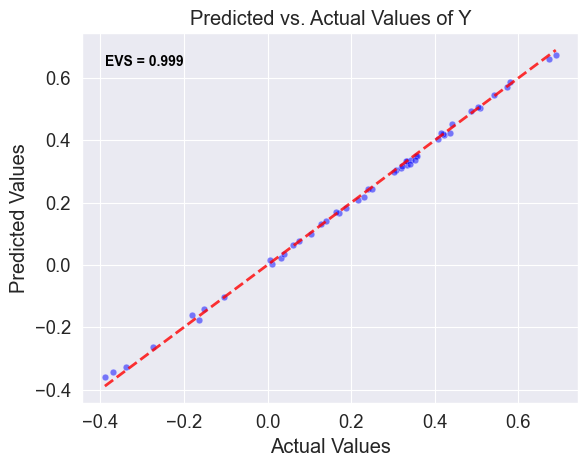

In [15]:
## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 0.5, 1]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           scoring = 'neg_mean_squared_error', 
                           cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train_unchanged, y = y_train_unchanged)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test_unchanged)

## Compute the MSE
mse = mean_squared_error(y_true = y_test_unchanged, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test_unchanged, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

plt.figure()

sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test_unchanged, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test_unchanged), max(y_test_unchanged)], [min(y_test_unchanged), max(y_test_unchanged)], linestyle='--', color='red', linewidth=2, alpha = 0.8)
plt.text(min(y_test_unchanged), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

#plt.savefig('Images/regression_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

Best Parameters: {'alpha': 0.01, 'gamma': 0.5}
Mean Square Error on the Test Set: 0.00010153329395795001
Explained Variance Score on the Test Set: 0.9985521806595208


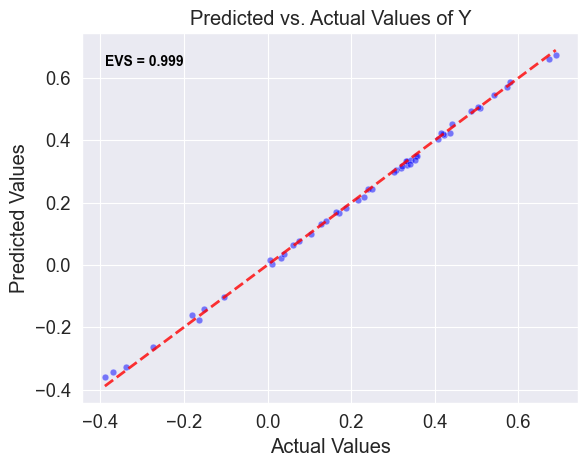

In [16]:
## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 0.5, 1]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           scoring = 'neg_mean_squared_error', 
                           cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train_self, y = y_train_self)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test_self)

## Compute the MSE
mse = mean_squared_error(y_true = y_test_self, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test_self, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

plt.figure()

sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test_self, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test_self), max(y_test_self)], [min(y_test_self), max(y_test_self)], linestyle='--', color='red', linewidth=2, alpha = 0.8)
plt.text(min(y_test_self), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

#plt.savefig('Images/regression_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

It seems to be performing the same way.

### Performing on the real dataset

In [ ]:
## Number of blade one want to consider.
_many_blades = 300

## Creating the list of all file numbers.
padded_numbers = [str(i).zfill(9) for i in range(_many_blades)]

## Lists that will holds the cloud points and the associated efficiency.
distributions = []
efficiency = []

for number in padded_numbers:
    ## File paths Google Colab
    #cgns_file_path = f'/content/drive/MyDrive/Developer/GraduationProject/Experimental Part/Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    #coefficient_file_path = f'/content/drive/MyDrive/Developer/GraduationProject/Experimental Part/Rotor37/dataset/samples/sample_{number}/scalars.csv'
    ## File paths Personal Computer
    cgns_file_path = f'Rotor37/dataset/samples/sample_{number}/meshes/mesh_000000000.cgns'
    coefficient_file_path = f'Rotor37/dataset/samples/sample_{number}/scalars.csv'
    ## Computing the coordinates
    x, y, z = read_cgns_coordinates(cgns_file_path)
    blade = np.column_stack((x, y, z))
    ## Computing the coefficient
    scalars = pd.read_csv(coefficient_file_path)
    ## Adding to our data
    distributions.append(blade)
    efficiency.append(scalars["Efficiency"][0])

## Train Test split of 70%
#x_train, x_test, y_train, y_test = train_test_split(distributions, efficiency, train_size = 0.7, random_state = 42)

In [ ]:
mu = distributions[0]

## Convert the list of points mu into a WeightedPointCloud object
mu_cloud = WeightedPointCloud(
    cloud=jnp.array(mu),
    weights=jnp.ones(mu_num_sample)
)

## First we convert the list all the sampled distributions to WeightedPointCloud objects
list_of_weighted_point_clouds = []
for sample in distributions:
    distrib_cloud = WeightedPointCloud(
        cloud=jnp.array(sample),
        weights=jnp.ones(len(sample))
    )
    list_of_weighted_point_clouds.append(distrib_cloud)

## We need to convert the cloud list to a VectorizedWeightedPointCloud
x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

## We choose our epsilon parameter and perform the sinkhirn algorithm
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, 
                                                   sinkhorn_solver_kwargs = sinkhorn_solver_kwargs, 
                                                   parallel = False, # going into the for loop
                                                   batch_size = -1)

## Our explicative data is now 'sinkhorn_potentials'.
## Then we train_test_split our X and Y data
x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, efficiency, train_size = 0.7, random_state = 42)

In [ ]:
## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 0.5, 1, 10, 100]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           scoring = 'neg_mean_squared_error', 
                           cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train, y = y_train)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test)

## Compute the MSE
mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

plt.figure()

sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha = 0.8)
plt.text(min(y_test), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

#plt.savefig('Images/regression_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()